In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)


<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [3]:
product_list = ["IF", "IH", "IC", "T", "TF"]

In [4]:
period = 4096

In [6]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1149


1149

In [7]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [10]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
new_date = "20200529"
out_sample = all_dates>=new_date
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
sum(out_sample)

57

In [11]:
def add_min_max(file, period_list):
    data = load(file)
    for period in period_list:
        data["min."+str(period)] = data["wpr"].rolling(period).min()
        data.loc[:period-1, ("min."+str(period))] = np.minimum.accumulate(data["wpr"].iloc[:period-1])
        #data.loc[:period-1, ("min."+str(period))] = data["wpr"][0]
        
        data["max."+str(period)] = data["wpr"].rolling(period).max()
        data.loc[:period-1, ("max."+str(period))] = np.maximum.accumulate(data["wpr"].iloc[:period-1])
        #data.loc[:period-1, ("max."+str(period))] = data["wpr"][0]
    
    save(data, file)

In [12]:
%%time
new_dates = all_dates[all_dates>=new_date]
new_dates.sort()
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
    parLapply(CORE_NUM, file_list, add_min_max, period_list=[1024, 2048, 4096])## Wall time: 1min 35s

# Wall time: 57.8 s


Wall time: 57.8 s


In [13]:
import dask
from dask import compute, delayed

In [14]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
n_signal = len(signal_list)

In [15]:
SAVE_PATH = "e:/intern"

In [16]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        if hasattr(x, "__len__"):
            res = np.zeros(len(x))
        else:
            res = 0
        
    return res

class foctor_total_trade_imb_period(factor_template):
    factor_name = "total.trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(zero_divide(ewma(data["buy.trade"]+data["buy2.trade"]-data["sell.trade"]-data["sell2.trade"], period, adjust=True), 
                           ewma(data["qty"], period, adjust=True)),1).values

class foctor_trade_imb_period(factor_template):
    factor_name = "trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma(zero_divide(data["buy.trade"] - data["sell.trade"], data["buy.trade"] + data["sell.trade"]), period, adjust=True).values


from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True)).values

from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period).values
    
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values
    
from collections import OrderedDict
class foctor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

from collections import OrderedDict
class foctor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

class foctor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True).values

class foctor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True), round(period/5), adjust=True).values

from collections import OrderedDict
class foctor_std_period(factor_template):
    factor_name = "std.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return np.sqrt(fast_roll_var(data["wpr"], period))


from collections import OrderedDict
class foctor_range_period(factor_template):
    factor_name = "range.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return data["max."+str(period)]-data["min."+str(period)]
    
from collections import OrderedDict
class foctor_volume_open_ratio_period(factor_template):
    factor_name = "volume.open.ratio.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(cum(data["qty"],period), cum(data["cum.open.int"]/period,period))

from collections import OrderedDict
class foctor_trend_index_period(factor_template):
    factor_name = "trend.index.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        aa = zero_divide(abs(data["wpr"]-data["wpr"].shift(period)), data["max."+str(period)]-data["min."+str(period)])
        aa[0:period]=0
        return aa

def get_atr(file, product, period_list, spread, SAVE_PATH="e:/intern"):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/spread
        save(S, SAVE_PATH+"/tmp pkl/"+product+"/atr."+str(period)+"/" + file[-12:])

class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

- Now we generate all the signals one by one for the new data

In [17]:
x1 = foctor_trade_imb_period()
x2 = foctor_total_trade_imb_period()
x3 = foctor_nr_period()
x4 = foctor_dbook_period()
x5 = foctor_range_pos_period()
x6 = foctor_price_osci_period()
x7 = foctor_ma_diff_period()
x8 = foctor_kdj_j_period()
x9 = foctor_kdj_k_period()
x10 = foctor_range_period()
x11 = foctor_std_period()
x12 = foctor_volume_open_ratio_period()
x13 = foctor_trend_index_period()

In [18]:
new_dates = all_dates[all_dates>=new_date]
new_dates.sort()
len(new_dates)

57

In [19]:
import os
SAVE_PATH = "e:/intern"
for product in product_list:
    os.makedirs(SAVE_PATH + "/tmp pkl/" + product, exist_ok=True)

In [20]:
all_signal_list = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13]
for product in product_list:
    for xx in all_signal_list:
        create_signal_path(xx, product, SAVE_PATH)

e:/intern/tmp pkl/IF/trade.imb.1024
e:/intern/tmp pkl/IF/trade.imb.2048
e:/intern/tmp pkl/IF/trade.imb.4096
e:/intern/tmp pkl/IF/total.trade.imb.1024
e:/intern/tmp pkl/IF/total.trade.imb.2048
e:/intern/tmp pkl/IF/total.trade.imb.4096
e:/intern/tmp pkl/IF/nr.1024
e:/intern/tmp pkl/IF/nr.2048
e:/intern/tmp pkl/IF/nr.4096
e:/intern/tmp pkl/IF/dbook.1024
e:/intern/tmp pkl/IF/dbook.2048
e:/intern/tmp pkl/IF/dbook.4096
e:/intern/tmp pkl/IF/range.pos.1024
e:/intern/tmp pkl/IF/range.pos.2048
e:/intern/tmp pkl/IF/range.pos.4096
e:/intern/tmp pkl/IF/price.osci.1024
e:/intern/tmp pkl/IF/price.osci.2048
e:/intern/tmp pkl/IF/price.osci.4096
e:/intern/tmp pkl/IF/ma.dif.10.1024
e:/intern/tmp pkl/IF/ma.dif.10.2048
e:/intern/tmp pkl/IF/ma.dif.10.4096
e:/intern/tmp pkl/IF/kdj.j.1024
e:/intern/tmp pkl/IF/kdj.j.2048
e:/intern/tmp pkl/IF/kdj.j.4096
e:/intern/tmp pkl/IF/kdj.k.1024
e:/intern/tmp pkl/IF/kdj.k.2048
e:/intern/tmp pkl/IF/kdj.k.4096
e:/intern/tmp pkl/IF/range.1024
e:/intern/tmp pkl/IF/range.2048


In [21]:
%%time
i = 0
all_signal_list = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13]
for xx in all_signal_list:
    for product in product_list:
        print("signal ",i,product)
        file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=SAVE_PATH)
    i = i + 1


signal  0 IF
signal  0 IH
signal  0 IC
signal  0 T
signal  0 TF
signal  1 IF
signal  1 IH
signal  1 IC
signal  1 T
signal  1 TF
signal  2 IF
signal  2 IH
signal  2 IC
signal  2 T
signal  2 TF
signal  3 IF
signal  3 IH
signal  3 IC
signal  3 T
signal  3 TF
signal  4 IF
signal  4 IH
signal  4 IC
signal  4 T
signal  4 TF
signal  5 IF
signal  5 IH
signal  5 IC
signal  5 T
signal  5 TF
signal  6 IF
signal  6 IH
signal  6 IC
signal  6 T
signal  6 TF
signal  7 IF
signal  7 IH
signal  7 IC
signal  7 T
signal  7 TF
signal  8 IF
signal  8 IH
signal  8 IC
signal  8 T
signal  8 TF
signal  9 IF
signal  9 IH
signal  9 IC
signal  9 T
signal  9 TF
signal  10 IF
signal  10 IH
signal  10 IC
signal  10 T
signal  10 TF
signal  11 IF
signal  11 IH
signal  11 IC
signal  11 T
signal  11 TF
signal  12 IF
signal  12 IH
signal  12 IC
signal  12 T
signal  12 TF
Wall time: 13min 59s


In [22]:
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["range", "std", "volume.open.ratio", "trend.index"]
period_list = np.power(2, range(10,13))

In [23]:
def construct_composite_signal(dire_signal, range_signal, period_list, date_list, product_list, HEAD_PATH):
    from collections import OrderedDict
    class foctor_xx_period(factor_template):
        factor_name = dire_signal+"."+range_signal+".period"
        params = OrderedDict([
            ("period", period_list)
        ])
        def formula(self, data, period):
            return (data[dire_signal+"."+str(period)]*data[range_signal+"."+str(period)]).values
    xx = foctor_xx_period()
    for product in product_list:
        create_signal_path(xx, product, HEAD_PATH)
        file_list = [DATA_PATH+product+"/"+date for date in date_list]
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=HEAD_PATH)

In [24]:
%%time
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        construct_composite_signal(dire_signal, range_signal, period_list, new_dates, product_list, SAVE_PATH)

## Wall time: 36min 39s

e:/intern/tmp pkl/IF/trade.imb.range.1024
e:/intern/tmp pkl/IF/trade.imb.range.2048
e:/intern/tmp pkl/IF/trade.imb.range.4096
e:/intern/tmp pkl/IH/trade.imb.range.1024
e:/intern/tmp pkl/IH/trade.imb.range.2048
e:/intern/tmp pkl/IH/trade.imb.range.4096
e:/intern/tmp pkl/IC/trade.imb.range.1024
e:/intern/tmp pkl/IC/trade.imb.range.2048
e:/intern/tmp pkl/IC/trade.imb.range.4096
e:/intern/tmp pkl/T/trade.imb.range.1024
e:/intern/tmp pkl/T/trade.imb.range.2048
e:/intern/tmp pkl/T/trade.imb.range.4096
e:/intern/tmp pkl/TF/trade.imb.range.1024
e:/intern/tmp pkl/TF/trade.imb.range.2048
e:/intern/tmp pkl/TF/trade.imb.range.4096
e:/intern/tmp pkl/IF/total.trade.imb.range.1024
e:/intern/tmp pkl/IF/total.trade.imb.range.2048
e:/intern/tmp pkl/IF/total.trade.imb.range.4096
e:/intern/tmp pkl/IH/total.trade.imb.range.1024
e:/intern/tmp pkl/IH/total.trade.imb.range.2048
e:/intern/tmp pkl/IH/total.trade.imb.range.4096
e:/intern/tmp pkl/IC/total.trade.imb.range.1024
e:/intern/tmp pkl/IC/total.trade.imb.

In [25]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
    #parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=[4096], spread=spread) 
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(10,13)), spread=spread) 


Wall time: 29.1 s


In [26]:
def count_daily_num(x, period):
    data = load(x)
    return np.floor(sum(data["good"])/period)

In [27]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, HEAD_PATH+"/daily num/"+product+".pkl")

# Wall time: 6min 9s



Wall time: 6min 9s


In [28]:
def get_signal_mat(signal_mat, signal_name, product, file_name, HEAD_PATH):
    S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file_name)
    S[np.isnan(S)] = 0
    if signal_mat is None:
        return S
    else:
        return np.vstack((signal_mat, S))


In [29]:
def par_get_signal_mat(file_name, product, signal_list, HEAD_PATH, SAVE_PATH):
    signal_mat = functools.reduce(functools.partial(get_signal_mat, product=product, file_name=file_name, HEAD_PATH=SAVE_PATH), signal_list, None)
    save(signal_mat, SAVE_PATH+"/signal mat pkl/"+product+"/"+file_name)

In [30]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/signal mat pkl/"+product, exist_ok=True)

In [31]:
%%time
for product in product_list:
    print(product)
    parLapply(CORE_NUM, new_dates, par_get_signal_mat, 
              product=product, signal_list=signal_list, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
    
# IF
# IH
# IC
# T
# TF
# Wall time: 1min 22s

IF
IH
IC
T
TF
Wall time: 1min 22s


- we test several models:
- in-sample/out-sample lasso of week 9
- rolling lasso of week 9
- medium frequency lasso of week 11

In [32]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)

In [33]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-4]
signal_names
col_names = ori_mat.columns

In [34]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
print(product_list[0], train_mat.shape)
for product in product_list[1:3]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)
    
# IF (2045, 49)
# IH (1431, 49)
# IC (2048, 49)


IF (2045, 49)
IH (1431, 49)
IC (2048, 49)


In [36]:
result = forward_selected(train_mat[train_mat.columns[:-3]], "ret."+str(period))

In [52]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = np.array([signal+".4096" for signal in all_signal_list])
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])
n_signal = len(signal_list)

In [54]:
pos = [np.where(signal_list==x)[0][0] for x in result["chosen.signals"]]
pos

[18, 27, 43, 17, 23, 24, 5, 10, 14, 26, 9]

In [55]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [56]:
#x_train = train_mat.iloc[:, :n_sigl].values
x_train = train_mat[result["chosen.signals"]]
#x_train = train_mat[signal_list[chosen_signals]]
y_train = train_mat.loc[:, y_signal].values
print(np.shape(x_train))
scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
fit_coef = np.zeros(n_signal)
fit_coef[pos] = model.coef_/x_std
print(fit_coef)

# (5524, 11)
# [ 0.          0.          0.          0.          0.         -0.05195899
#   0.          0.          0.          0.09357218 -0.0425371   0.
#   0.          0.         -0.35163503  0.          0.          0.19263128
#  -0.08827555  0.          0.          0.          0.          0.55179563
#  -0.11277601  0.         -0.26074473  0.01137263  0.          0.
#   0.          0.          0.          0.          0.          0.
#   0.          0.          0.          0.          0.          0.
#   0.          0.02213094  0.        ]


(5524, 11)
[ 0.          0.          0.          0.          0.         -0.05195899
  0.          0.          0.          0.09357218 -0.0425371   0.
  0.          0.         -0.35163503  0.          0.          0.19263128
 -0.08827555  0.          0.          0.          0.          0.55179563
 -0.11277601  0.         -0.26074473  0.01137263  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.02213094  0.        ]


In [57]:
coef_list=dict([])
for product in product_list[:3]:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])

IF
price.osci.4096                    -0.000587
trade.imb.range.4096                0.000615
total.trade.imb.range.4096         -0.000135
price.osci.range.4096              -0.000140
kdj.j.range.4096                    0.000077
trade.imb.std.4096                 -0.002539
price.osci.std.4096                 0.000895
ma.dif.10.std.4096                 -0.011869
kdj.j.std.4096                     -0.000434
trade.imb.volume.open.ratio.4096    0.022328
kdj.k.trend.index.4096              0.000336
dtype: float64
IH
price.osci.4096                    -0.000645
trade.imb.range.4096                0.001381
total.trade.imb.range.4096         -0.000233
price.osci.range.4096              -0.000206
kdj.j.range.4096                    0.000112
trade.imb.std.4096                 -0.005568
price.osci.std.4096                 0.001313
ma.dif.10.std.4096                 -0.016948
kdj.j.std.4096                     -0.000609
trade.imb.volume.open.ratio.4096    0.021724
kdj.k.trend.index.4096            

In [58]:
strat = "overall.lasso."+str(period)
   
for product in product_list[:3]:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [59]:
%%time
for product in product_list[:3]:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, new_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
    
# IF
# IH
# IC
# Wall time: 39.4 s


IF
IH
IC
Wall time: 39.4 s


In [60]:
def get_good(date, product, HEAD_PATH, SAVE_PATH):
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+date)
    good = data["good"]
    save(good, SAVE_PATH+"/good pkl/"+product+"/"+date)  

In [61]:
%%time
for product in product_list[0:3]:
    parLapply(CORE_NUM, new_dates, get_good, product=product, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern")
    
#Wall time:28.8 s

Wall time: 16.4 s


In [66]:
#%%time
#for product in product_list[0:3]:
#    par_get_all_signal(strat, all_dates[all_dates, product, 4096, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern", DATA_PATH="e:/intern")
    
# Wall time:  2min 25s

Wall time: 2min 25s


In [63]:
%%time
for product in product_list[:3]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("overall.lasso", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                    period=4096, split_str="2018", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# Wall time: 7min 55s


reverse=1
reverse=1
reverse=1
Wall time: 7min 55s


IF train sharpe  0.5382723555283818 test sharpe  0.8656782629045178
IH train sharpe  0.3015850553271201 test sharpe  -0.18657467309098427
IC train sharpe  0.5217126788528591 test sharpe  0.7907038316906893
train sharpe:  0.6174139012165428 test sharpe:  0.7075859453955425


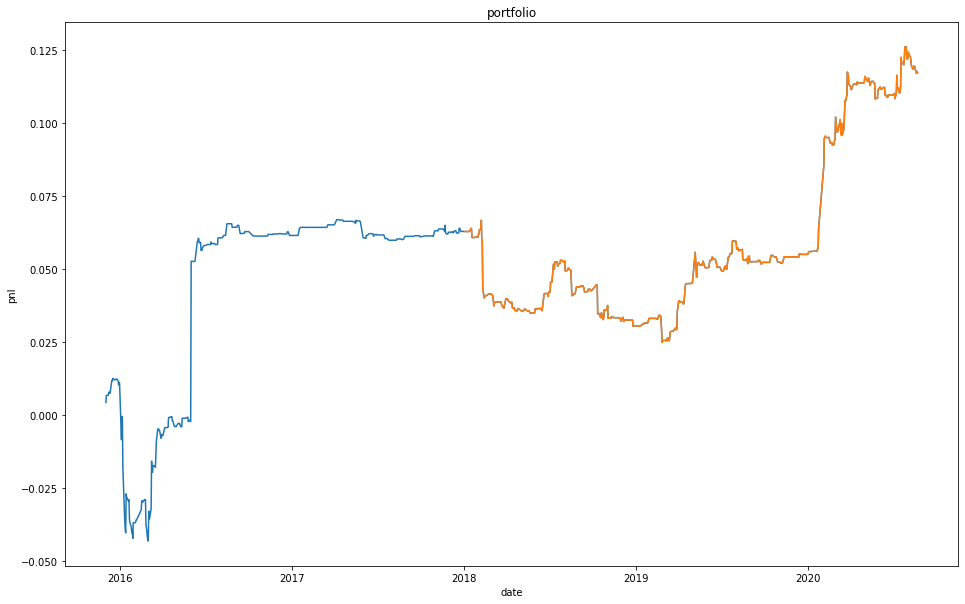

In [208]:
i = 0
strat = "overall.lasso.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list[:3]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
train_test_portfolio = all_portfolio
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))  

# IF train sharpe  0.5382723555283818 test sharpe  0.8656782629045178
# IH train sharpe  0.3015850553271201 test sharpe  -0.18657467309098427
# IC train sharpe  0.5217126788528591 test sharpe  0.7907038316906893
# train sharpe:  0.6174139012165428 test sharpe:  0.7075859453955425



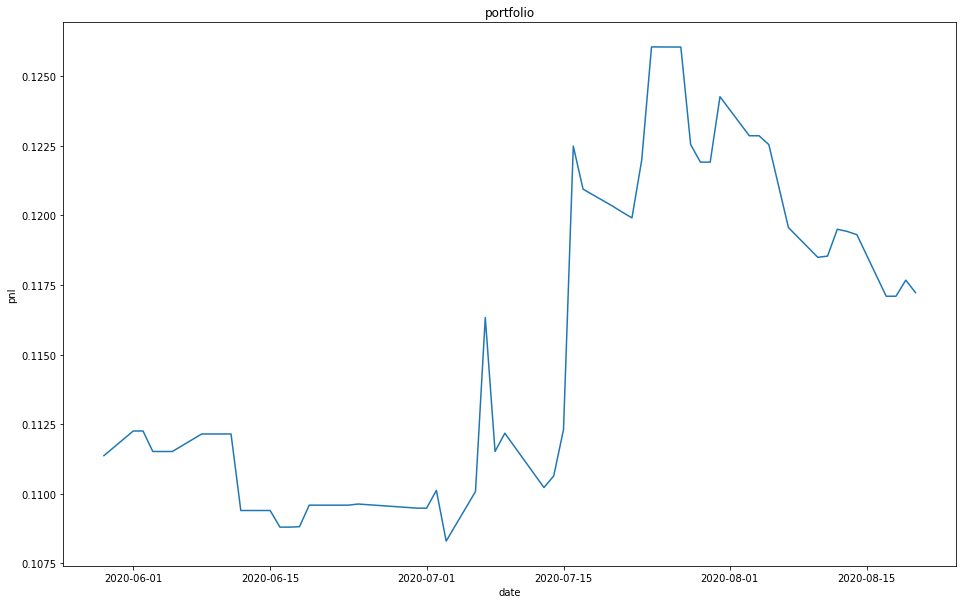

In [348]:
out_sample = all_dates>="20200529"
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates[out_sample], all_portfolio.cumsum()[out_sample])

- we can see that the out-sample portfolio is quite good
- now we go to the rolling lasso model

In [66]:
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < "2018")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [67]:
month = np.array([file[:6] for file in all_dates])
month_len = np.unique(month, return_counts=True)
month_len

# (array(['201512', '201601', '201602', '201603', '201604', '201605',
#         '201606', '201607', '201608', '201609', '201610', '201611',
#         '201612', '201701', '201702', '201703', '201704', '201705',
#         '201706', '201707', '201708', '201709', '201710', '201711',
#         '201712', '201801', '201802', '201803', '201804', '201805',
#         '201806', '201807', '201808', '201809', '201810', '201811',
#         '201812', '201901', '201902', '201903', '201904', '201905',
#         '201906', '201907', '201908', '201909', '201910', '201911',
#         '201912', '202001', '202002', '202003', '202004', '202005',
#         '202006', '202007', '202008'], dtype='<U6'),
#  array([22, 20, 16, 23, 20, 21, 20, 21, 23, 20, 16, 22, 22, 18, 18, 23, 18,
#         20, 22, 21, 23, 21, 17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19,
#         18, 22, 20, 22, 15, 21, 21, 20, 19, 23, 22, 20, 18, 21, 22, 16, 20,
#         22, 20, 18, 20, 22, 14], dtype=int64))

(array(['201512', '201601', '201602', '201603', '201604', '201605',
        '201606', '201607', '201608', '201609', '201610', '201611',
        '201612', '201701', '201702', '201703', '201704', '201705',
        '201706', '201707', '201708', '201709', '201710', '201711',
        '201712', '201801', '201802', '201803', '201804', '201805',
        '201806', '201807', '201808', '201809', '201810', '201811',
        '201812', '201901', '201902', '201903', '201904', '201905',
        '201906', '201907', '201908', '201909', '201910', '201911',
        '201912', '202001', '202002', '202003', '202004', '202005',
        '202006', '202007', '202008'], dtype='<U6'),
 array([22, 20, 16, 23, 20, 21, 20, 21, 23, 20, 16, 22, 22, 18, 18, 23, 18,
        20, 22, 21, 23, 21, 17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19,
        18, 22, 20, 22, 15, 21, 21, 20, 19, 23, 22, 20, 18, 21, 22, 16, 20,
        22, 20, 18, 20, 22, 14], dtype=int64))

In [68]:
test_range = month_len[0] > "2018"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
cum_month_len = np.cumsum(month_len[1])
month_len[1][test_range]

# array([22, 15, 22, 18, 22, 20, 22, 23, 19, 18, 22, 20, 22, 15, 21, 21, 20,
#        19, 23, 22, 20, 18, 21, 22, 16, 20, 22, 20, 18, 20, 22, 14],
#       dtype=int64)

array([22, 15, 22, 18, 22, 20, 22, 23, 19, 18, 22, 20, 22, 15, 21, 21, 20,
       19, 23, 22, 20, 18, 21, 22, 16, 20, 22, 20, 18, 20, 22, 14],
      dtype=int64)

In [99]:
new_start = np.where(month_len[0]>="202005")[0][0]
new_start
## 53

53

In [100]:
month_len[0]

array(['201512', '201601', '201602', '201603', '201604', '201605',
       '201606', '201607', '201608', '201609', '201610', '201611',
       '201612', '201701', '201702', '201703', '201704', '201705',
       '201706', '201707', '201708', '201709', '201710', '201711',
       '201712', '201801', '201802', '201803', '201804', '201805',
       '201806', '201807', '201808', '201809', '201810', '201811',
       '201812', '201901', '201902', '201903', '201904', '201905',
       '201906', '201907', '201908', '201909', '201910', '201911',
       '201912', '202001', '202002', '202003', '202004', '202005',
       '202006', '202007', '202008'], dtype='<U6')

In [101]:
month_len[0][test_range]

# array(['201801', '201802', '201803', '201804', '201805', '201806',
#        '201807', '201808', '201809', '201810', '201811', '201812',
#        '201901', '201902', '201903', '201904', '201905', '201906',
#        '201907', '201908', '201909', '201910', '201911', '201912',
#        '202001', '202002', '202003', '202004', '202005', '202006',
#        '202007', '202008'], dtype='<U6')

array(['201801', '201802', '201803', '201804', '201805', '201806',
       '201807', '201808', '201809', '201810', '201811', '201812',
       '201901', '201902', '201903', '201904', '201905', '201906',
       '201907', '201908', '201909', '201910', '201911', '201912',
       '202001', '202002', '202003', '202004', '202005', '202006',
       '202007', '202008'], dtype='<U6')

In [102]:
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample])
    n_days = sum(sample)
    n_signal = len(signal_list)
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        good = load(SAVE_PATH+"/good pkl/"+product+"/"+file)  
        chosen = (np.arange(sum(good))+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            S = S[good]
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

In [75]:
class foctor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
y1 = foctor_ret_period()

class foctor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
y2 = foctor_ret_period_002()

class foctor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
y3 = foctor_ret_period_001()

class foctor_ret_period_004(factor_template):
    factor_name = "ret.period.004"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.041).values
y4 = foctor_ret_period_004()

In [76]:
%%time
i = 0
all_pred_list = [y1,y2,y3,y4]
for xx in all_pred_list:
    for product in product_list[0:3]:
        print("pred ",i,product)
        file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=SAVE_PATH)
    i = i + 1
    
# pred  0 IF
# pred  0 IH
# pred  0 IC
# pred  1 IF
# pred  1 IH
# pred  1 IC
# pred  2 IF
# pred  2 IH
# pred  2 IC
# pred  3 IF
# pred  3 IH
# pred  3 IC
# Wall time: 2min 25s

pred  0 IF
pred  0 IH
pred  0 IC
pred  1 IF
pred  1 IH
pred  1 IC
pred  2 IF
pred  2 IH
pred  2 IC
pred  3 IF
pred  3 IH
pred  3 IC
Wall time: 2min 25s


In [77]:
%%time
for product in product_list[0:3]:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    out_mat = get_sample_signal(all_dates, out_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002","ret."+str(period)+".004"]), 
                                  period, daily_num)
    save(out_mat, HEAD_PATH+"/train test mat/"+product+".out.mat.pkl")

# IF
# IH
# IC
# Wall time: 1min 30s



IF
IH
IC
Wall time: 1min 30s


In [103]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list[:3]:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    out_mat = load(HEAD_PATH+"/train test mat/"+product+".out.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [104]:
from sklearn.preprocessing import StandardScaler

In [105]:
test_range = np.where(month_len[0] > "2018" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2018")-1
cum_month_len = np.cumsum(month_len[1])

# ['201801' '201802' '201803' '201804' '201805' '201806' '201807' '201808'
#  '201809' '201810' '201811' '201812' '201901' '201902' '201903' '201904'
#  '201905' '201906' '201907' '201908' '201909' '201910' '201911' '201912'
#  '202001' '202002' '202003' '202004' '202005' '202006' '202007' '202008']

['201801' '201802' '201803' '201804' '201805' '201806' '201807' '201808'
 '201809' '201810' '201811' '201812' '201901' '201902' '201903' '201904'
 '201905' '201906' '201907' '201908' '201909' '201910' '201911' '201912'
 '202001' '202002' '202003' '202004' '202005' '202006' '202007' '202008']


In [106]:
train_tick_start = dict([]) ## startting ticks of training set
train_tick_end = dict([])   ## ending ticks of training set
cum_daily_ticks = dict([]) ## cumulative of number of ticks by product
train_mat = np.zeros((0,n_signal))
train_end = cum_month_len[end_month]-1
y_train = np.array([])
for product in product_list[:3]: ## combine data sets together and then fit the model
    cum_daily_ticks[product] = daily_ticks[product].cumsum()
    train_tick_start[product] = 0
    train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1) 
    x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
    cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
    scaler.fit(x_train)
    x_train = scaler.transform(x_train) ## normalize data before combine
    train_std_mat[product] = np.sqrt(scaler.var_)
    train_mat = np.append(train_mat,x_train, axis=0)
    y_train = np.append(y_train, cur_y_train)

In [107]:
train_mat = pd.DataFrame(train_mat, columns=signal_list)
train_mat[y_signal] = y_train
result = forward_selected(train_mat, y_signal)
pos = [np.where(signal_list==x)[0][0] for x in result["chosen.signals"]]

In [108]:
## training multiple products together with rolling model
## train_start: start day to train
## train_end: end day to train
## forward_len: length of test sets
## strat: name of strategy
## single_product: the products that need to train separately
## combine_product: the products that need to train together
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          single_product, combine_product, period=4096, SAVE_PATH="e:/intern"):
    product_list = np.append(single_product, combine_product) ## all of the products
    cum_daily_ticks = dict([]) ## cumulative of number of ticks by product
    train_tick_start = dict([]) ## startting ticks of training set
    train_tick_end = dict([])   ## ending ticks of training set
    test_tick_start = dict([]) ## startting ticks of test set
    test_tick_end = dict([]) ## ending ticks of test set
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1) 
        ## the last tick would use future data that in the test sample for response variable y, so we need to minus 1 here
        test_tick_start[product] = int(train_tick_end[product]+2) ## we minus 1 in train_tick_end, so need to plus 2 for test_tick_start
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1]) ## we only use 1 month as test sample so plus 1 here
    coef_list = dict([])
    for product in single_product: ## train products in single_product separately 
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        n_train = x_train.shape[0]
        scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
        scaler.fit(x_train)
        x_std = np.sqrt(scaler.var_)
        x_train_normal = scaler.transform(x_train)
        model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
        coef = model.coef_ / x_std
        coef_list[product] = coef
    train_std_mat = dict([])
    y_std = dict([])
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in combine_product: ## combine data sets together and then fit the model
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train) ## normalize data before combine
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_std[product] = np.std(cur_y_train)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    train_mat = pd.DataFrame(train_mat, columns=signal_list)
    train_mat[y_signal] = y_train
    result = forward_selected(train_mat, y_signal)
    x_train = train_mat[result["chosen.signals"]]
    pos = [np.where(signal_list==x)[0][0] for x in result["chosen.signals"]]
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train) ## normalized the combined data again
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    fit_coef = np.zeros(n_signal)
    fit_coef[pos] = model.coef_/x_std ## transform to the value before second normaliztion
    #model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(train_mat, y_train)
    #fit_coef = model.coef_
    for product in combine_product:
        coef_list[product] = fit_coef*y_std[product]/train_std_mat[product] ## transform to the value before the first normalization
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [157]:
coef_list = load(SAVE_PATH+"/model/roll.lasso.4096.202007.pkl")

In [109]:
test_range = np.where(month_len[0] > "2018" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2018")-1
cum_month_len = np.cumsum(month_len[1])

['201801' '201802' '201803' '201804' '201805' '201806' '201807' '201808'
 '201809' '201810' '201811' '201812' '201901' '201902' '201903' '201904'
 '201905' '201906' '201907' '201908' '201909' '201910' '201911' '201912'
 '202001' '202002' '202003' '202004' '202005' '202006' '202007' '202008']


In [110]:
%%time
strat = "roll.lasso.4096"
y_signal = "ret.4096"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    if i_test>=new_start:
        get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                              [], product_list[:3], period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1
    
# 25 201801
# 26 201802
# 27 201803
# 28 201804
# 29 201805
# 30 201806
# 31 201807
# 32 201808
# 33 201809
# 34 201810
# 35 201811
# 36 201812
# 37 201901
# 38 201902
# 39 201903
# 40 201904
# 41 201905
# 42 201906
# 43 201907
# 44 201908
# 45 201909
# 46 201910
# 47 201911
# 48 201912
# 49 202001
# 50 202002
# 51 202003
# 52 202004
# 53 202005
# Wall time: 15.6 s

25 201801
26 201802
27 201803
28 201804
29 201805
30 201806
31 201807
32 201808
33 201809
34 201810
35 201811
36 201812
37 201901
38 201902
39 201903
40 201904
41 201905
42 201906
43 201907
44 201908
45 201909
46 201910
47 201911
48 201912
49 202001
50 202002
51 202003
52 202004
53 202005
54 202006
55 202007
56 202008
Wall time: 2min 48s


In [113]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
strat_name = "roll.lasso.4096"
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    if i_test>=new_start:
        strat_name = strat+"."+month_len[0][i_test]
        coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
        for product in product_list[:3]:
            coef = coef_list[product]
            os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
            parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 
                      product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 25 201801
# 26 201802
# 27 201803
# 28 201804
# 29 201805
# 30 201806
# 31 201807
# 32 201808
# 33 201809
# 34 201810
# 35 201811
# 36 201812
# 37 201901
# 38 201902
# 39 201903
# 40 201904
# 41 201905
# 42 201906
# 43 201907
# 44 201908
# 45 201909
# 46 201910
# 47 201911
# 48 201912
# 49 202001
# 50 202002
# 51 202003
# 52 202004
# 53 202005
# Wall time: 50min 27s

25 201801
26 201802
27 201803
28 201804
29 201805
30 201806
31 201807
32 201808
33 201809
34 201810
35 201811
36 201812
37 201901
38 201902
39 201903
40 201904
41 201905
42 201906
43 201907
44 201908
45 201909
46 201910
47 201911
48 201912
49 202001
50 202002
51 202003
52 202004
53 202005
54 202006
55 202007
56 202008
Wall time: 6min 56s


In [116]:
%%time
strat = "roll.lasso.4096"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    if i_test>=new_start:
        for product in product_list[:3]:
            par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, 
                               SAVE_PATH = "e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 201801 20151202.pkl 20171229.pkl
# 201802 20160104.pkl 20180131.pkl
# 201803 20160201.pkl 20180228.pkl
# 201804 20160301.pkl 20180330.pkl
# 201805 20160401.pkl 20180427.pkl
# 201806 20160503.pkl 20180531.pkl
# 201807 20160601.pkl 20180629.pkl
# 201808 20160701.pkl 20180731.pkl
# 201809 20160801.pkl 20180831.pkl
# 201810 20160901.pkl 20180928.pkl
# 201811 20161010.pkl 20181031.pkl
# 201812 20161101.pkl 20181130.pkl
# 201901 20161201.pkl 20181228.pkl
# 201902 20170103.pkl 20190131.pkl
# 201903 20170203.pkl 20190228.pkl
# 201904 20170301.pkl 20190329.pkl
# 201905 20170405.pkl 20190430.pkl
# 201906 20170502.pkl 20190531.pkl
# 201907 20170601.pkl 20190628.pkl
# 201908 20170703.pkl 20190731.pkl
# 201909 20170801.pkl 20190830.pkl
# 201910 20170901.pkl 20190930.pkl
# 201911 20171009.pkl 20191031.pkl
# 201912 20171101.pkl 20191129.pkl
# 202001 20171201.pkl 20191231.pkl
# 202002 20180102.pkl 20200123.pkl
# 202003 20180201.pkl 20200228.pkl
# 202004 20180301.pkl 20200331.pkl
# 202005 20180402.pkl 20200430.pkl
# Wall time: 4min 8s


201801 20151202.pkl 20171229.pkl
201802 20160104.pkl 20180131.pkl
201803 20160201.pkl 20180228.pkl
201804 20160301.pkl 20180330.pkl
201805 20160401.pkl 20180427.pkl
201806 20160503.pkl 20180531.pkl
201807 20160601.pkl 20180629.pkl
201808 20160701.pkl 20180731.pkl
201809 20160801.pkl 20180831.pkl
201810 20160901.pkl 20180928.pkl
201811 20161010.pkl 20181031.pkl
201812 20161101.pkl 20181130.pkl
201901 20161201.pkl 20181228.pkl
201902 20170103.pkl 20190131.pkl
201903 20170203.pkl 20190228.pkl
201904 20170301.pkl 20190329.pkl
201905 20170405.pkl 20190430.pkl
201906 20170502.pkl 20190531.pkl
201907 20170601.pkl 20190628.pkl
201908 20170703.pkl 20190731.pkl
201909 20170801.pkl 20190830.pkl
201910 20170901.pkl 20190930.pkl
201911 20171009.pkl 20191031.pkl
201912 20171101.pkl 20191129.pkl
202001 20171201.pkl 20191231.pkl
202002 20180102.pkl 20200123.pkl
202003 20180201.pkl 20200228.pkl
202004 20180301.pkl 20200331.pkl
202005 20180402.pkl 20200430.pkl
202006 20180502.pkl 20200529.pkl
202007 201

In [117]:
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < "2018")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        if i_test>=new_start:
            all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
            open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
            thre_list = []
            for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
                thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
            thre_list = np.array(thre_list)
            thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
            train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                                 product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                                 max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                                atr_filter=atr_filter, rebate=0)
            train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
            test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                                product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                                 max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                                atr_filter=atr_filter, rebate=0)
            test_stat = get_hft_summary(test_result, thre_mat, forward_len)
            stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
            save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [282]:
%%time
strat = "roll.lasso.4096"
for product in product_list[0:3]:
    get_lasso_roll_result(product, strat, test_range, month_len, atr_filter=20)



IF 25 roll.lasso.4096.201801
IF 26 roll.lasso.4096.201802
IF 27 roll.lasso.4096.201803
IF 28 roll.lasso.4096.201804
IF 29 roll.lasso.4096.201805
IF 30 roll.lasso.4096.201806
IF 31 roll.lasso.4096.201807
IF 32 roll.lasso.4096.201808
IF 33 roll.lasso.4096.201809
IF 34 roll.lasso.4096.201810
IF 35 roll.lasso.4096.201811
IF 36 roll.lasso.4096.201812
IF 37 roll.lasso.4096.201901
IF 38 roll.lasso.4096.201902
IF 39 roll.lasso.4096.201903
IF 40 roll.lasso.4096.201904
IF 41 roll.lasso.4096.201905
IF 42 roll.lasso.4096.201906
IF 43 roll.lasso.4096.201907
IF 44 roll.lasso.4096.201908
IF 45 roll.lasso.4096.201909
IF 46 roll.lasso.4096.201910
IF 47 roll.lasso.4096.201911
IF 48 roll.lasso.4096.201912
IF 49 roll.lasso.4096.202001
IF 50 roll.lasso.4096.202002
IF 51 roll.lasso.4096.202003
IF 52 roll.lasso.4096.202004
IF 53 roll.lasso.4096.202005


KeyboardInterrupt: 

sharpe  0.5466232889020591


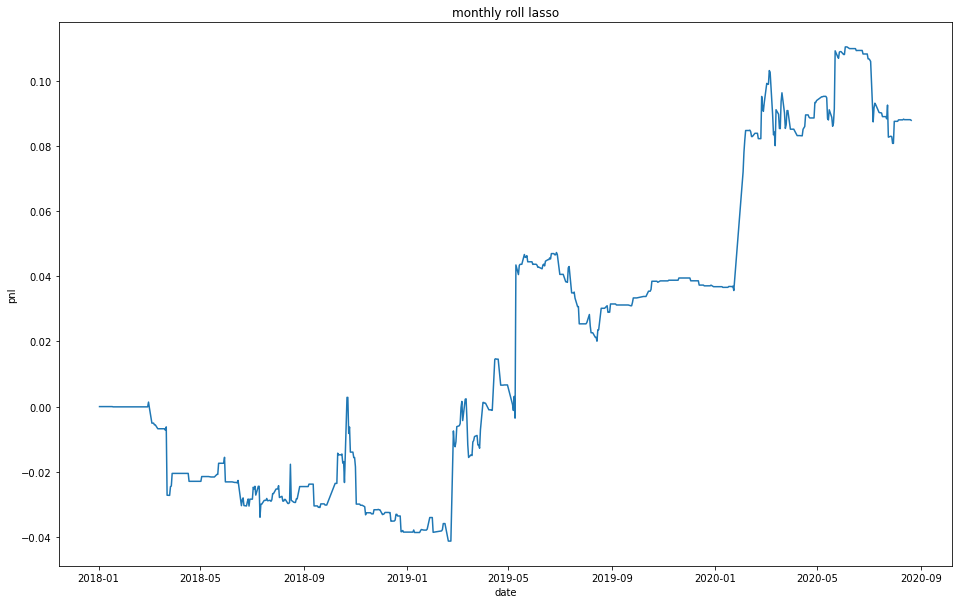

In [358]:
n_product = len(product_list[0:3])
save_path = "signal result atr"
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.lasso.4096"
start_month = 0
min_pnl = 10
min_num = 20
end_month = sum(month_len[0] < "2018")-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    avg_test_pnl = test_mat.mean(axis=1)
    #avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #print(len(avg_test_pnl_mean)==len(avg_test_pnl))
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    #print(all_pnl)
    #print(len(all_pnl), len(avg_test_pnl))
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], all_pnl.cumsum());
print("sharpe ", sharpe(all_pnl))

## sharpe  0.7461707241443614  ## avg
## sharpe  1.4661086101373344 ## sharpe
## sharpe  1.739788502944618 ## risk parity
## sharpe  1.7661071787278613 ## diagonal risk parity


In [213]:
out_sample = all_dates[test_sample]>="20200529"
len(rolling_portfolio[out_sample])

57

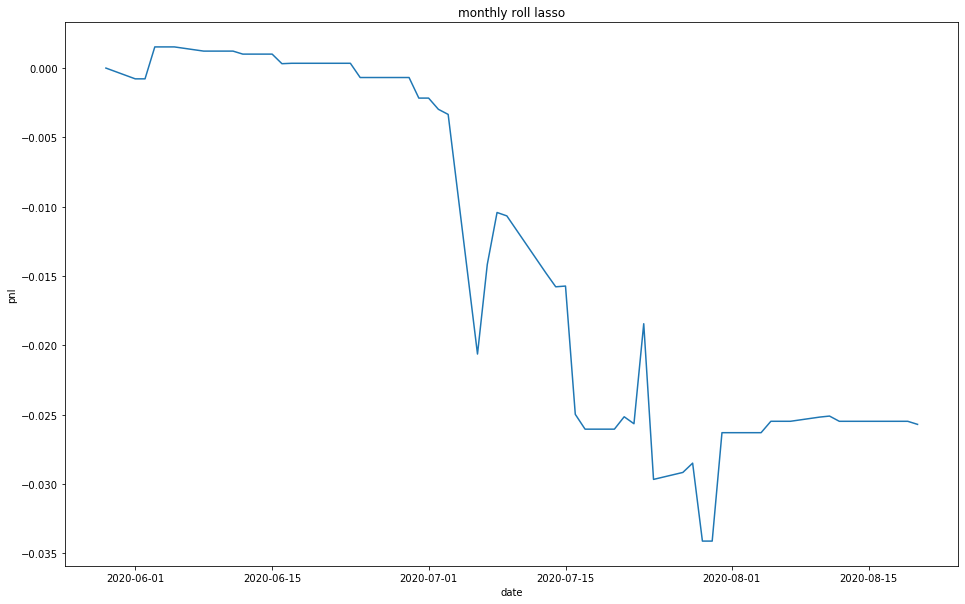

In [219]:
out_sample = all_dates[test_sample]>="20200529"
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample][out_sample], rolling_portfolio[out_sample].cumsum());

- we can see that the result is not so good but acceptable